In [ ]:
#Importing Packages
import spacy
import nltk
from nltk import word_tokenize, pos_tag
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
#nltk.download('stopwords')
from gensim.corpora import Dictionary
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, HdpModel
#Packages for the visualization
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [ ]:
nltk.download('stopwords')

## using functions to create bigram ,trigram, adjuctive and noun 

### Data Pre Processing:
### Using Spacy and nltk for preprocessing

In [ ]:
#Pre-Processing
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
def Activity_norm(text):
    if text == 'DELIVERY PARTIAL' or text=='BOTH DELIVERY PICK UP PARTIAL' or text=='OTHER SERVICESPartial' or text=='RELOCATION PARTIAL': 
        return('PARTIAL')
    elif text=='DELIVERY CANCELLED RESCHEDULED' or text=='BOTH DELIVERY PICK UP CANCELLED RESCHEDULED' or text == 'RELOCATION CANCELLED RESCHEDULED' or text== 'OTHER SERVICESCancelled Re scheduled':
        return('CANCELLED')
    else:
        return(text)
def remove_stopwords(texts):
    stop_words= stopwords.words("english")
    stop_words.extend(['please','other','reason','unit,','pm','today','tomorrow','plz'])
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigram(texts):
    return [Bigram_mode[doc] for doc in texts]
def make_trigram(texts):
    return [Trigram_mod[doc] for doc in texts]
def Lemmatize(texts,allowed_postags=['NOUN','VERB','ADJ','ADV']):
    text_out=[]
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        text_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return text_out
def compute_coherence_values(id2word, cropus,lemma_data, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=lemma_data, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [ ]:
#Data Import'
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    df=pd.read_excel("Feedbaacks_file_1.xlsx")
    df1=pd.read_excel("Feedbaacks_file_2.xlsx", sheet_name='DB')

In [ ]:
#Data Merging/..
Comment=pd.concat([df['CRM_Remarks'],df1['CEM Reasons']])
Activity=pd.concat([df['ACTIVITY_STATUS_TYPE'],df1['Activity Type']])
data=pd.DataFrame({"Comment":Comment,"Activity":Activity})
data=data.dropna()

In [ ]:
# Data Pre Processing 
# This section is your data specific and 
datax=data
datax['Activity']=datax['Activity'].map(lambda text: " ".join(re.findall('\w+',str(text))))
datax['Activity']=datax['Activity'].map(lambda text: Activity_norm(text))
datax['Activity']=datax['Activity'].map(lambda text: text.lower())
datax=datax[datax['Activity']!=3]
datax=datax[datax['Activity']!='completed']

In [ ]:
#Text Pre-Processing
datax['Comment']=datax['Comment'].apply(lambda text: re.sub(r'\(.*\)','',str(text))) #deleting the values inside the bracket
data_words=list(sent_to_words(datax["Comment"])) #using the self made function
Bigram=gensim.models.Phrases(data_words, min_count=5,threshold=100)
Trigram=gensim.models.Phrases(Bigram[data_words],min_count=5,threshold=100)
Bigram_mode=gensim.models.phrases.Phraser(Bigram)
Trigram_mod=gensim.models.phrases.Phraser(Trigram)

In [ ]:
#Text pre-processing

#removing the stopwords 
data_words_nonstop=remove_stopwords(data_words)

#making bigrams
bigram_data=make_bigram(data_words_nonstop)

#making trigrams
#rigram_data=make_trigram(bigram_data)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

#lemmatization
lemma_data=Lemmatize(bigram_data, allowed_postags=['NOUN','VERB','ADJ','ADV'])

## Count vectorizer

In [ ]:
#For testing the frequncy of the different word
cv=CountVectorizer(max_df=0.95, min_df=50, stop_words="english")
x=cv.fit_transform([' '.join(text) for text in lemma_data])
counter=pd.DataFrame(x.todense(),columns=cv.get_feature_names())

In [ ]:
#Frequency of the top 100 words
sum_words = x.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
Top_words=words_freq[:100]

In [ ]:
Top_word

## Gensim lda 

In [ ]:
#creating dictionary and corpus
id2word = corpora.Dictionary(lemma_data)
texts=lemma_data
corpus = [id2word.doc2bow(text) for text in texts]
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [ ]:
#Fitting the model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8,
                                           random_state=111,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
print(lda_model.print_topics())

In [ ]:
#Extraxting only topics from the matrix 
topics=' //Topic\\: '.join([' '.join([''.join(tup[0]) for tup in sent[1]]) for sent in lda_model.show_topics(num_topics=20,formatted =False)])
topics

## Sklearn lda

In [ ]:
skl_texts=[' '.join(text) for text in lemma_data]
no_features = 1000
# NMF(Non negetive Matrix Factorization ) is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(skl_texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(skl_texts)
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

no_top_words = 10
#display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

## sklearn Hdp model

In [ ]:
#hdp = HdpModel(corpus=corpus, id2word=id2word)
#[' '.join([''.join(tup[0]) for tup in sent[1]]) for sent in hdp.show_topics(formatted =False)]

# visualization

In [ ]:
#Visuallization of the results
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=lemma_data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
model_list, coherence_values = compute_coherence_values(id2word, corpus, lemma_data, 40, 2, 6)

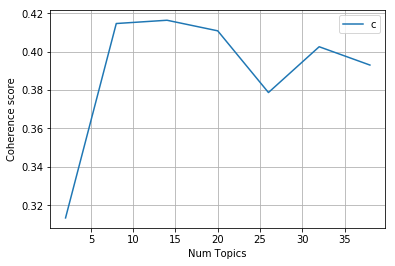

In [19]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()